In [104]:
import pandas as pd
import numpy as np

## Statistiques

In [172]:
path = "Data/Classement thématique des sujets de journeaux télévisés/ina-barometre-jt-tv-donnees-quotidiennes-2000-2020-nbre-sujets-durees-202410.csv" 
df = pd.read_csv(path, encoding="latin-1", sep=";", header=None)
df.describe()


,2,4,5
count,0.0,268424.000000,268424.000000
mean,NaN,2.184745,194.009098
std,NaN,1.917227,203.621299
min,NaN,1.000000,1.000000
25%,NaN,1.000000,89.000000
50%,NaN,2.000000,134.000000
75%,NaN,3.000000,242.000000
max,NaN,102.000000,16125.000000


In [173]:
themes = df[3].unique()
chaines = df[1].unique()
df_eff = pd.DataFrame(columns=themes, index=chaines)

for th in themes:
    for ch in chaines:
        temps = df[(df[1]==ch) & (df[3]==th)][5].sum()
        df_eff.loc[ch, th] = temps

df_eff = df_eff.astype(float)
df_freq = df_eff / df_eff.sum().sum()
df_lig = df_freq / df_freq.sum()
df_col = df_freq.T / df_freq.sum(axis=1)

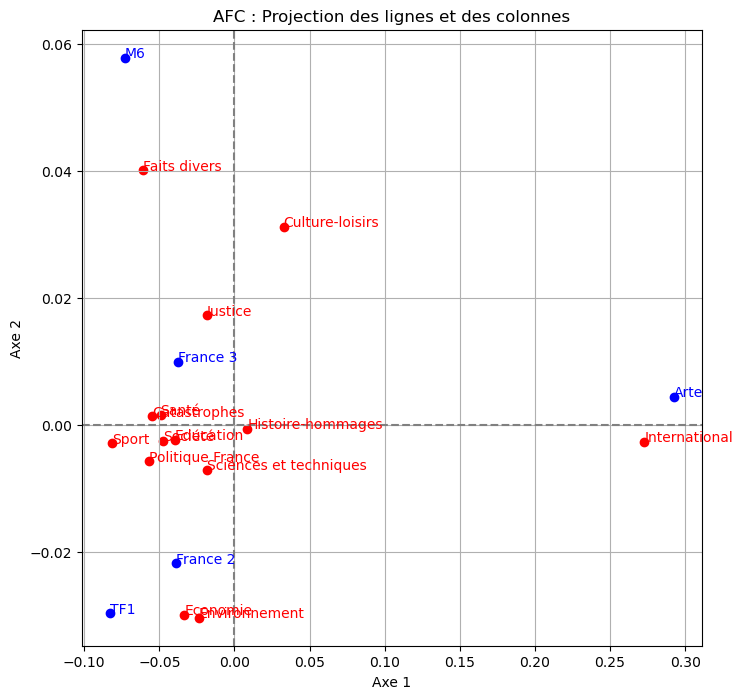

Inertie expliquée par chaque axe : [9.28126260e-01 4.43872503e-02 2.32062642e-02 4.28022561e-03
 7.21501451e-32]


In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Étape 1 : Calcul des fréquences relatives
n_total = df_eff.values.sum()
P = df_eff / n_total  # Matrice de probabilités
row_sums = P.sum(axis=1)  # Totaux des lignes
col_sums = P.sum(axis=0)  # Totaux des colonnes

# Étape 2 : Matrice centrée et réduite (matrice de résidus)
E = np.outer(row_sums, col_sums).astype(float)  # Matrice attendue sous hypothèse d'indépendance
Z = (P - E) / np.sqrt(E)  # Matrice des résidus du Chi2

# Étape 3 : Décomposition en valeurs singulières (SVD)
U, s, Vt = np.linalg.svd(Z, full_matrices=False)

# Étape 4 : Calcul des coordonnées factorielles
row_coordinates = U * s  # Coordonnées des lignes
col_coordinates = Vt.T * s  # Coordonnées des colonnes

# Étape 5 : Visualisation des résultats
plt.figure(figsize=(8, 8))
plt.axhline(0, linestyle='--', color='grey')
plt.axvline(0, linestyle='--', color='grey')

# Coordonnées des lignes
for i, (x, y) in enumerate(zip(row_coordinates[:, 0], row_coordinates[:, 1])):
    plt.scatter(x, y, label=df_eff.index[i], color='blue')
    plt.text(x, y, df_eff.index[i], color='blue')

# Coordonnées des colonnes
for i, (x, y) in enumerate(zip(col_coordinates[:, 0], col_coordinates[:, 1])):
    plt.scatter(x, y, label=df_eff.columns[i], color='red')
    plt.text(x, y, df_eff.columns[i], color='red')

plt.title('AFC : Projection des lignes et des colonnes')
plt.xlabel('Axe 1')
plt.ylabel('Axe 2')
plt.grid()
plt.show()

# Inertie expliquée par chaque axe
explained_inertia = (s ** 2) / np.sum(s ** 2)
print("Inertie expliquée par chaque axe :", explained_inertia)

